In [3]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [4]:
xlsx_path = './Data/20250725 20240909 Visualization (Adolescent)_Logistic Regression.xlsx'

In [5]:
df = pd.read_excel(xlsx_path).dropna()
df = df.drop(columns=['ID'])
df.info()
df.columns
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Chronic TMD                     158 non-null    int64  
 1   VAS-I                           158 non-null    int64  
 2   Treatment duration              158 non-null    float64
 3   Female                          158 non-null    int64  
 4   Age                             158 non-null    int64  
 5   VAS-F                           158 non-null    int64  
 6   TMJ OA on PR                    158 non-null    int64  
 7   ADD on MRI                      158 non-null    int64  
 8   TMJ OA on MRI                   158 non-null    int64  
 9   TMJ noise                       158 non-null    int64  
 10  TMD pain                        158 non-null    int64  
 11  Muscle stiffness                158 non-null    int64  
 12  Locking                         158 

,Chronic TMD,VAS-I,Treatment duration,Female,Age,VAS-F,TMJ OA on PR,ADD on MRI,TMJ OA on MRI,TMJ noise,...,Headache,Orthodontic tx,Bad posture,Irregular diet,Anterior joint space,Posterior joint space,Naso-maxillary discrepancy,Maxillo-mandibular discrepancy,Body length discrepancy,Ramus height discrepancy
0,0,6,13.0,1,10,2,1,1,1,1,...,0,0,1,1,3.065,1.940,2.20,2.80,4.14,3.01
1,0,6,7.0,1,12,1,0,0,0,1,...,0,1,0,0,1.840,2.885,2.60,2.40,2.68,5.26
2,0,0,8.0,2,12,0,1,1,1,1,...,0,0,0,0,2.630,3.440,0.00,0.00,5.83,0.74
3,0,3,0.0,2,12,0,0,0,1,0,...,0,1,1,0,1.945,2.300,0.00,0.00,1.37,1.84
4,0,0,0.0,2,12,0,0,0,0,1,...,1,0,1,0,2.955,3.505,0.00,0.00,0.09,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,1,5,15.0,2,18,0,0,1,0,1,...,0,0,1,0,2.020,3.010,1.47,0.00,2.06,5.01
154,1,2,4.0,1,18,0,0,1,0,0,...,0,0,0,0,1.980,3.185,0.00,1.94,4.93,0.19
155,1,2,6.0,1,18,0,0,1,0,1,...,0,0,1,0,2.355,2.630,1.69,0.00,2.82,3.38
156,1,8,10.0,2,18,0,0,1,1,1,...,0,0,0,0,2.360,2.725,1.55,0.00,1.72,1.07


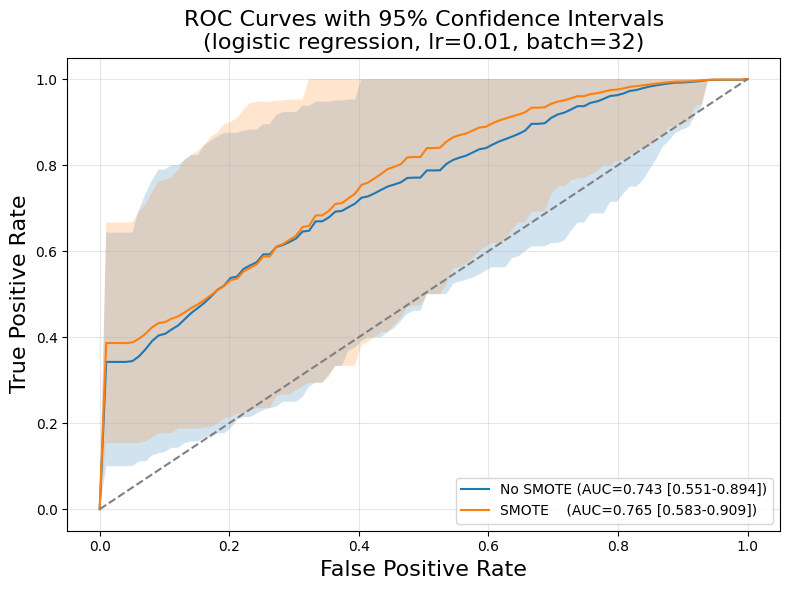

In [9]:
# ===============================================================
# ROC Curve with 95% CI for No SMOTE & SMOTE (best hyperparams)
# ===============================================================

# ── 1) 재현성 설정 ──
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 2) 데이터 로드 / 분할 ──
xlsx_path = '/content/drive/MyDrive/Adolescent TMD_Acute and Chronic TMD/20250725 20240909 Visualization (Adolescent)_Logistic Regression.xlsx'  # 실제 경로로 수정
df = pd.read_excel(xlsx_path).dropna()
X = df.drop(columns=['Chronic TMD']).values
y = df['Chronic TMD'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ── 3) 표준화 (Train-fit / Transform) ──
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ── 4) SMOTE 적용 (Train set only) ──
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# ── 5) Tensor 변환 & DataLoader ──
def to_tensor(arr, dtype=torch.float32):
    return torch.tensor(arr, dtype=dtype)

Xtr_no = to_tensor(X_train_scaled)
ytr_no = to_tensor(y_train)
Xtr_sm = to_tensor(X_res)
ytr_sm = to_tensor(y_res)
Xte     = to_tensor(X_test_scaled)
yte     = to_tensor(y_test)

best_lr = 0.01
best_bs = 32

loader_no = DataLoader(TensorDataset(Xtr_no, ytr_no), batch_size=best_bs, shuffle=True)
loader_sm = DataLoader(TensorDataset(Xtr_sm, ytr_sm), batch_size=best_bs, shuffle=True)
test_loader = DataLoader(TensorDataset(Xte, yte), batch_size=256, shuffle=False)

# ── 6) 모델 정의 ──
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.fc(x).squeeze(1)

model_no = LogisticRegressionModel(Xtr_no.shape[1]).to(device)
model_sm = LogisticRegressionModel(Xtr_sm.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
opt_no = optim.Adam(model_no.parameters(), lr=best_lr)
opt_sm = optim.Adam(model_sm.parameters(), lr=best_lr)

# ── 7) 학습 함수 ──
def train(model, loader, optimizer, epochs=100):
    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

train(model_no, loader_no, opt_no)
train(model_sm, loader_sm, opt_sm)

# ── 8) 테스트 세트 예측 확률 수집 ──
def get_probs(model, loader):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            prob = torch.sigmoid(logits).cpu().numpy()
            probs.append(prob)
            labels.append(yb.numpy())
    return np.concatenate(labels), np.concatenate(probs)

y_true, probs_no = get_probs(model_no, test_loader)
_,      probs_sm = get_probs(model_sm, test_loader)

# ── 9) ROC + 95% CI 계산 ──
def compute_roc_ci(y_true, y_prob, bootstraps=1000, seed=42):
    rng = np.random.default_rng(seed)
    base_fpr = np.linspace(0,1,100)
    tprs, aucs = [], []
    n = len(y_true)
    for _ in range(bootstraps):
        idx = rng.integers(0, n, n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[idx], y_prob[idx])
        interp_tpr = np.interp(base_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    lower_tpr = np.percentile(tprs, 2.5, axis=0)
    upper_tpr = np.percentile(tprs, 97.5, axis=0)
    mean_auc = auc(base_fpr, mean_tpr)
    auc_ci = np.percentile(aucs, [2.5, 97.5])
    return base_fpr, mean_tpr, lower_tpr, upper_tpr, mean_auc, auc_ci

fpr_no, m_tpr_no, lo_no, hi_no, auc_no, ci_no = compute_roc_ci(y_true, probs_no)
fpr_sm, m_tpr_sm, lo_sm, hi_sm, auc_sm, ci_sm = compute_roc_ci(y_true, probs_sm)

# ── 10) ROC 곡선 플롯 ──
plt.figure(figsize=(8,6))
plt.plot(fpr_no, m_tpr_no, label=f'No SMOTE (AUC={auc_no:.3f} [{ci_no[0]:.3f}-{ci_no[1]:.3f}])')
plt.fill_between(fpr_no, lo_no, hi_no, alpha=0.2)
plt.plot(fpr_sm, m_tpr_sm, label=f'SMOTE    (AUC={auc_sm:.3f} [{ci_sm[0]:.3f}-{ci_sm[1]:.3f}])')
plt.fill_between(fpr_sm, lo_sm, hi_sm, alpha=0.2)
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel('False Positive Rate', size = 16)
plt.ylabel('True Positive Rate', size = 16)
plt.title('ROC Curves with 95% Confidence Intervals\n(logistic regression, lr=0.01, batch=32)', size = 16)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

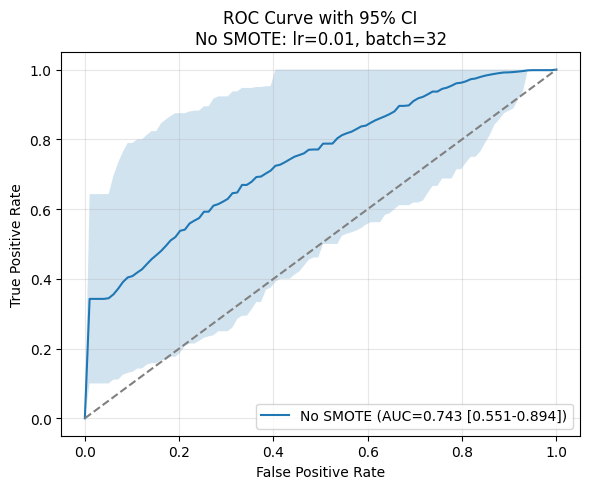

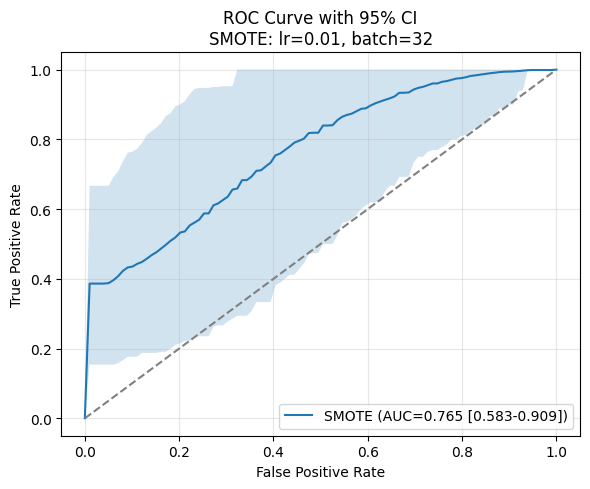

In [11]:
def plot_individual_roc(y_true, y_prob, label, best_lr, best_bs):
    # compute_roc_ci: base_fpr, mean_tpr, lower_tpr, upper_tpr, mean_auc, (ci_low, ci_high)
    fpr, mean_tpr, low_tpr, high_tpr, mean_auc, (ci_low, ci_high) = compute_roc_ci(y_true, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, mean_tpr, label=f'{label} (AUC={mean_auc:.3f} [{ci_low:.3f}-{ci_high:.3f}])')
    plt.fill_between(fpr, low_tpr, high_tpr, alpha=0.2)
    plt.plot([0,1],[0,1], '--', color='gray')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve with 95% CI\n{label}: lr={best_lr}, batch={best_bs}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# best hyperparameters
best_lr, best_bs = 0.01, 32

# No SMOTE
plot_individual_roc(y_true, probs_no, 'No SMOTE', best_lr, best_bs)

# SMOTE
plot_individual_roc(y_true, probs_sm, 'SMOTE', best_lr, best_bs)